Network Science FSS 2025

# Home Assignment 2

Submit your solution via Ilias by 23.59 on Friday, 28th March.

Submit your solutions in teams of 3-4 students. Unless explicitly agreed otherwise in advance, **submissions from teams with more or less members will NOT be graded**. Submit only one notebook per team. Only submit a notebook, do not submit the dataset(s) you used. Also, do NOT compress/zip your submission!

You may use the code from the exercises and basic functionalities that are explained in official documentation of Python packages without citing, __all other sources must be cited__. In case of plagiarism (copying solutions from other teams or from the internet) ALL team members may be expelled from the course without warning.

#### General guidelines:
* Make sure that your code is executable, any task for which the code does not directly run on our machine will be graded with 0 points.
* If you use packages that are not available on the default or conda-forge channel, list them below. Also add a link to installation instructions. 
* Ensure that the notebook does not rely on the current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
  * Do not rename any of the datasets you use, and load it from the same directory that your ipynb-notebook is located in, i.e., your working directory.
* Make sure you clean up your code before submission, e.g., properly align your code, and delete every line of code that you do not need anymore, even if you may have experimented with it. Minimize usage of global variables. Avoid reusing variable names multiple times!
* Ensure your code/notebook terminates in reasonable time.
* Feel free to use comments in the code. While we do not require them to get full marks, they may help us in case your code has minor errors.
* For questions that require a textual answer, please do not write the answer as a comment in a code cell, but in a Markdown cell below the code. Always remember to provide sufficient justification for all answers.
* You may create as many additional cells as you want, just make sure that the solutions to the individual tasks can be found near the corresponding assignment.
* If you have any general question regarding the understanding of some task, do not hesitate to post in the student forum in Ilias, so we can clear up such questions for all students in the course.

Additional packages (if any):
 - Example: `powerlaw`, https://github.com/jeffalstott/powerlaw

In [5]:
# general imports may go here!
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import warnings
from typing import List, Optional, Tuple, Dict
from scipy import sparse

### Task 1: Attacking the Train Bombing Network (22 pts)

We revisit the train bombing network from home assignment 1. This time, our focus lies on attacking the network.

In [7]:
G = nx.read_weighted_edgelist("train.edgelist", comments='%')
print('Nodes:', len(G.nodes()))
print('Edges:', len(G.edges()))

Nodes: 64
Edges: 243


#### a) Analyzing the degree distribution (2 pts)

Plot the degree distribution of the network. Argue whether or not it follows a power-law distribution.

(array([19., 17.,  4., 14.,  2.,  4.,  1.,  1.,  0.,  2.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <BarContainer object of 10 artists>)

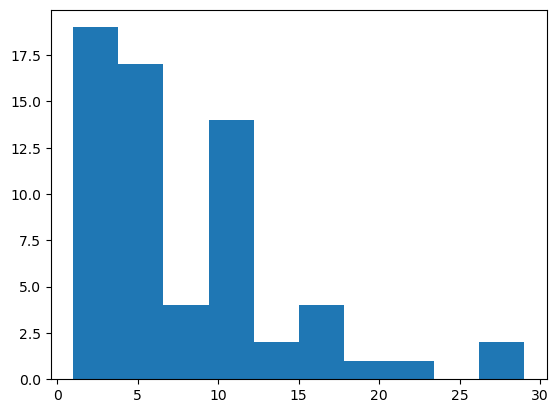

In [9]:
degrees = dict(G.degree()).values()
plt.hist(degrees) # uses numpy.histogram() default: bins=10

The degree distribution shows a clear tail, with most nodes having low degrees and only a few nodes having very high degrees.
This fits into the characteristcs of a scale-free network that follows the power-law distribution.

#### b) Attacking nodes (7 pts)

In this task we want to attack a network by deleting a node. Implement the following three attack strategies, using the function signature in the cell below:

(i) Deleting a random node,  
(ii) Deleting the highest degree node,  
(iii) Deleting the node with highest betweenness centrality.

Make sure that your implementation does not modify the original input network and that it returns the attacked network.

Finally, apply each attack function repeatedly on the train bombing network for the deletion of 20 nodes. For each attack type, start with the original (not attacked) network (or a copy thereof). Store the attacked networks (after 20 attacks) in ``G_random_attack``, ``G_degree_attack`` and ``G_bc_attack``. Plot the number of removed nodes (x-axis) against the share of the biggest connected component in the graph (y-axis) **after each node deletion** (starting at 0, i.e., no deleted node). Plot the curves of all three attacks in the same diagram. 

Which attack is the most efficient?

In [12]:
def attack(G: nx.Graph, strategy: str ='random') -> nx.Graph:
    """
    :param G: networkx graph we want to attack
    :param strategy: random (default), degree, betweenness. Attack strategy by which to select the node to delete
    :
    :return: resulting networkx graph after node deletion
    """
    
    G = G.copy()
    
    if strategy == 'random':
        node = random.choice(list(G.nodes()))
    
    elif strategy == 'degree':
        node = max(G.degree(), key =lambda x: x[1])[0]
    
    elif strategy == 'betweenness':
        centrality = nx.betweenness_centrality(G)
        node = max(centrality, key=centrality.get)
    
    G.remove_node(node)
    return G

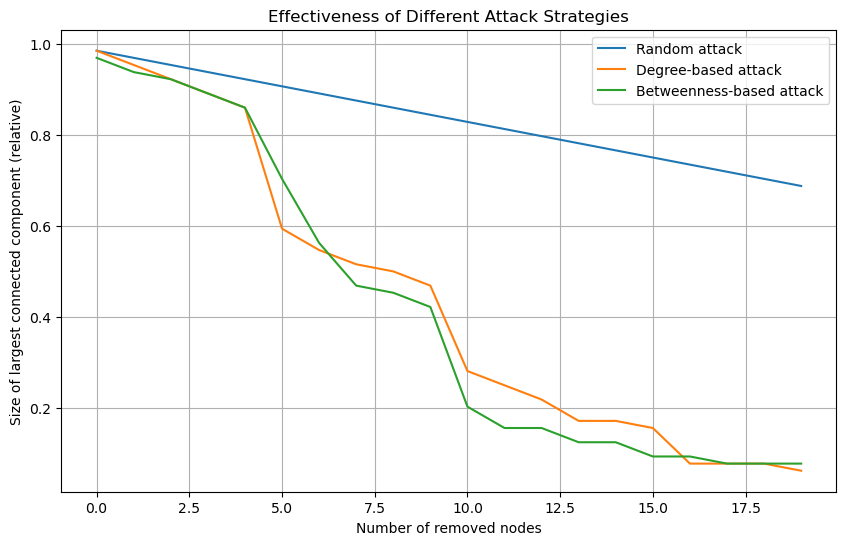

In [13]:
# create copies of original graph for each attack
G_random_attack = G.copy()
G_degree_attack = G.copy()
G_bc_attack = G.copy()

# Track size of largest connected component
largest_component_random = []
largest_component_degree = []
largest_component_bc = []


for _ in range(20):

    # Random attack
    G_random_attack = attack(G_random_attack, strategy='random')
    # Normalizing the size of the largest connected component
    largest_component_random.append(len(max(nx.connected_components(G_random_attack), key=len)) / len(G))

    # Degree attack
    G_degree_attack = attack(G_degree_attack, strategy='degree')
    largest_component_degree.append(len(max(nx.connected_components(G_degree_attack), key=len)) / len(G))

    # Betweenness attack
    G_bc_attack = attack(G_bc_attack, strategy='betweenness')
    largest_component_bc.append(len(max(nx.connected_components(G_bc_attack), key=len)) / len(G))


# plot attacks
plt.figure(figsize=(10, 6))
plt.plot(largest_component_random, label='Random attack')
plt.plot(largest_component_degree, label='Degree-based attack')
plt.plot(largest_component_bc, label='Betweenness-based attack')

plt.xlabel('Number of removed nodes')
plt.ylabel('Size of largest connected component (relative)')
plt.title('Effectiveness of Different Attack Strategies')
plt.legend()
plt.grid(True)
plt.show()


The most effective attack is the betweenness-based attack, as the green line in the plot drops steeply after just a few removed nodes.
The degree-based attack is also very effective, as the line drops steeply as well, although slightly slower than the betweenness-based attack.

#### c) Reconfiguring the network (4 pts)

Create ten configuration model networks with the same degree distribution as the train bombing network. For each of these networks, conduct the same attacks (on 20 nodes) with the same three strategies as in b). For each strategy, compute the average share of nodes in the giant components over all ten configuration model networks after each node deletion, and plot the average shares against the number of deleted nodes. Again, include the curves for all three attack strategies in the same plot. 

Which attack is most efficient on average? Would you say that the reconfigured network is more robust towards random and targeted attacks than the original networks? Explain your answers!

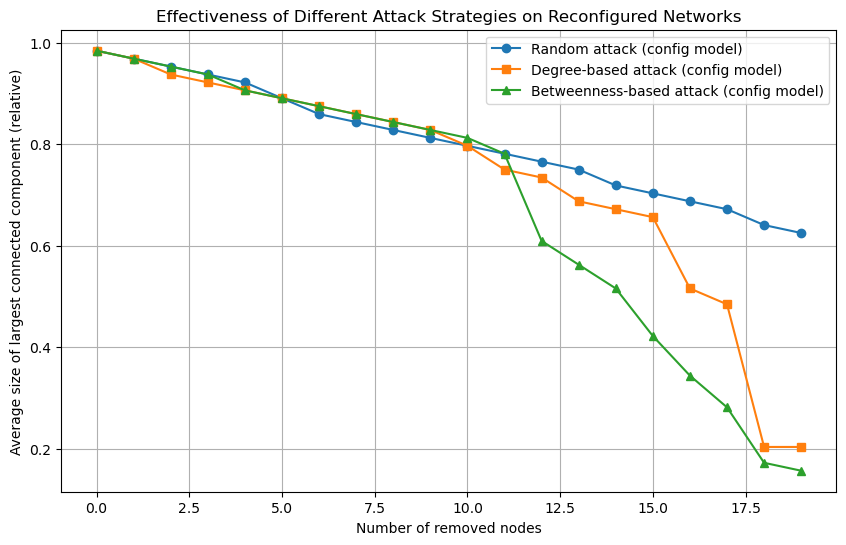

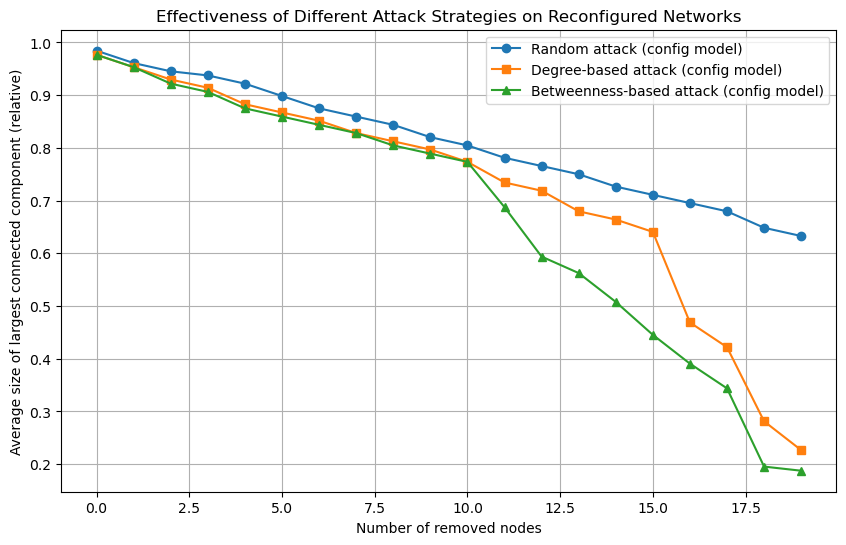

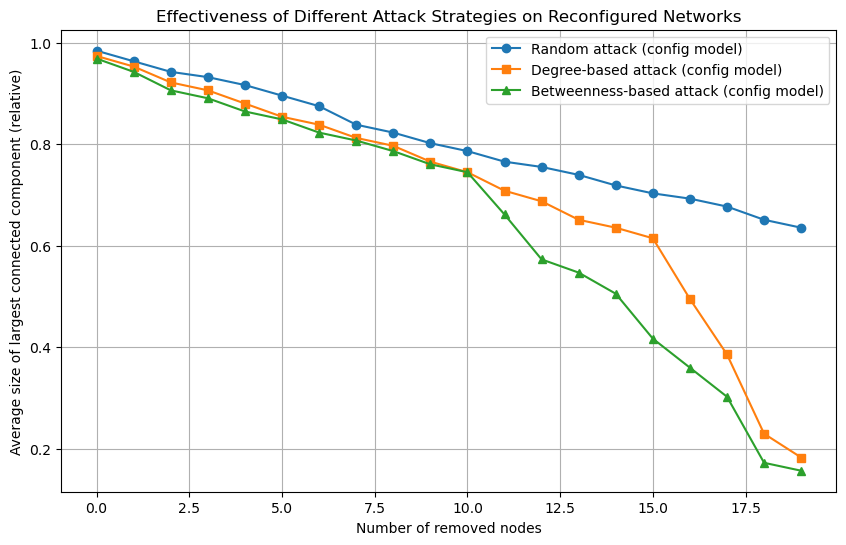

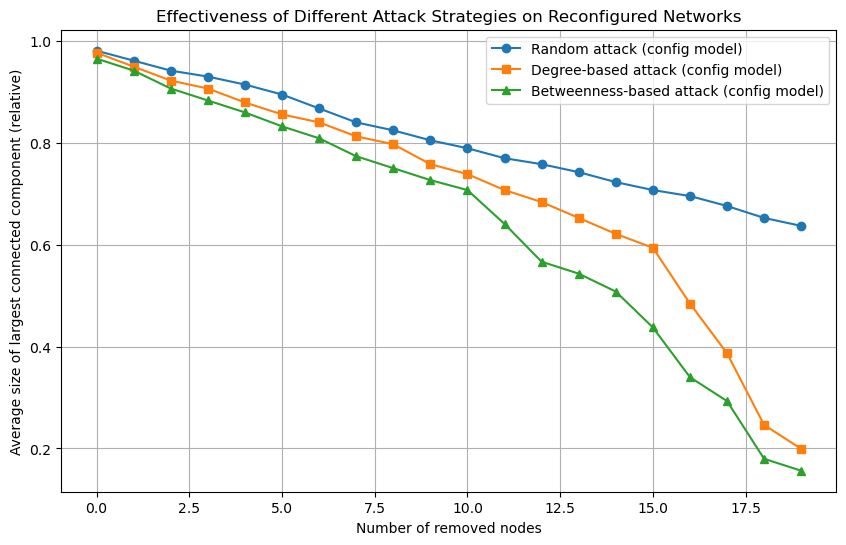

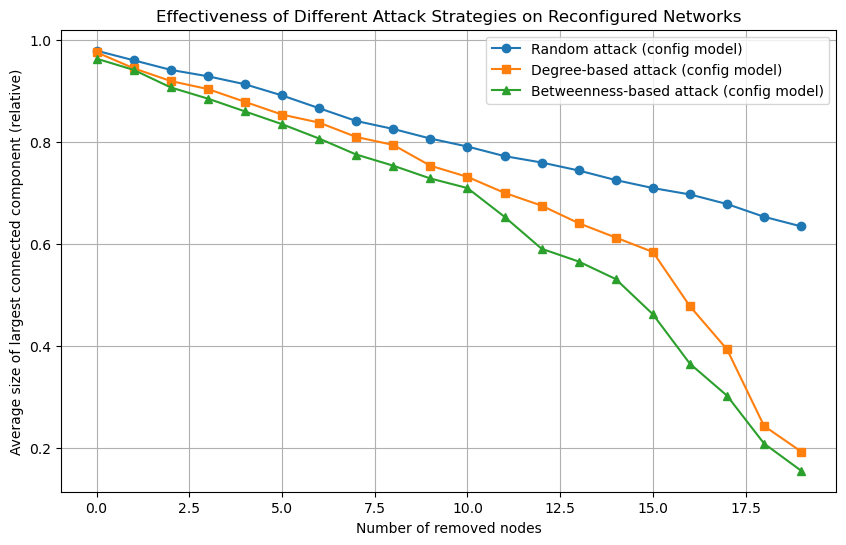

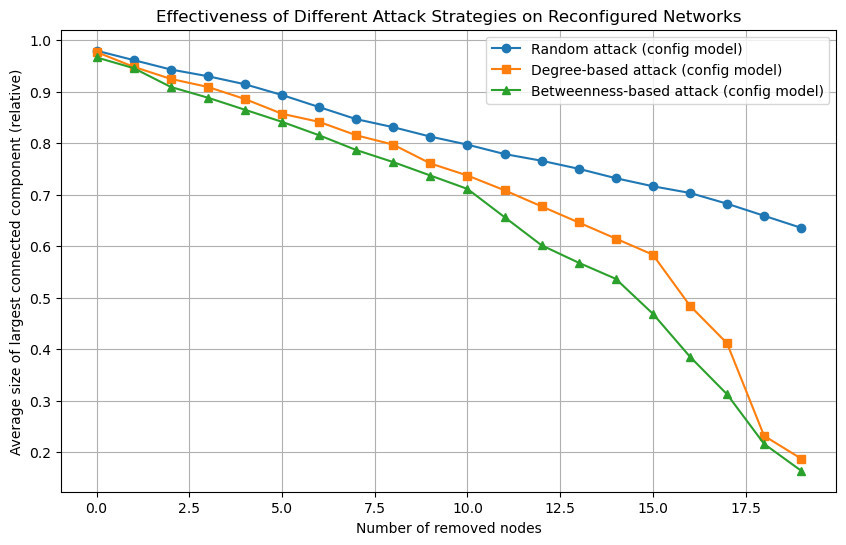

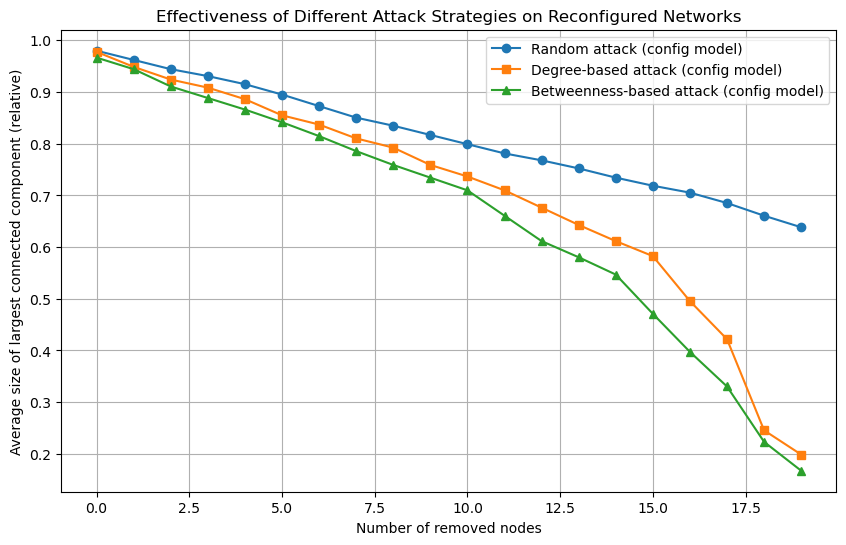

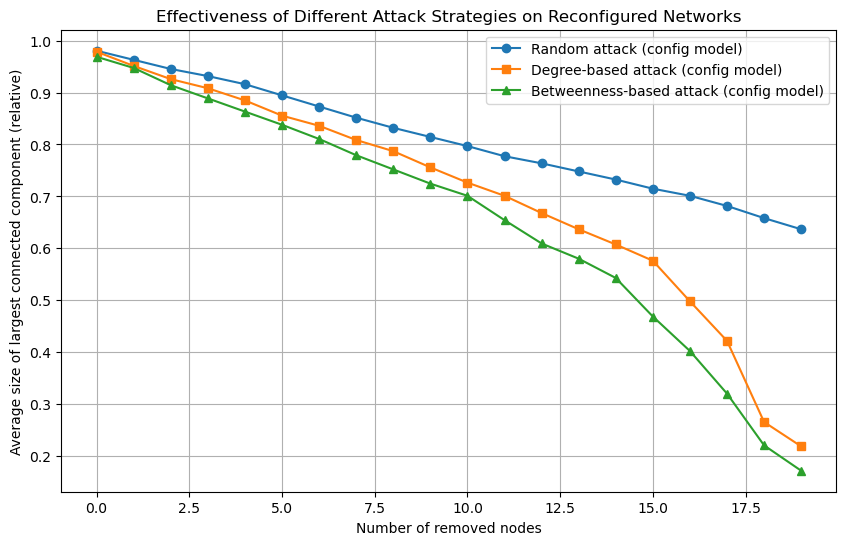

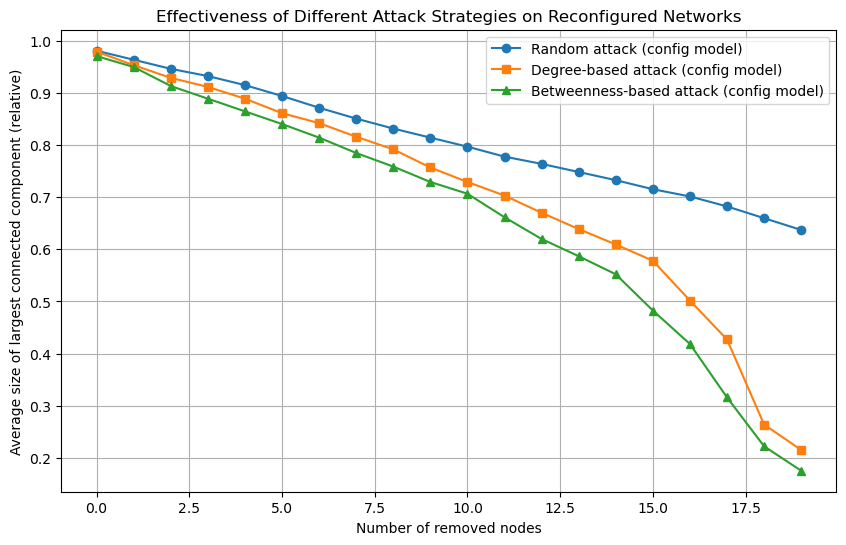

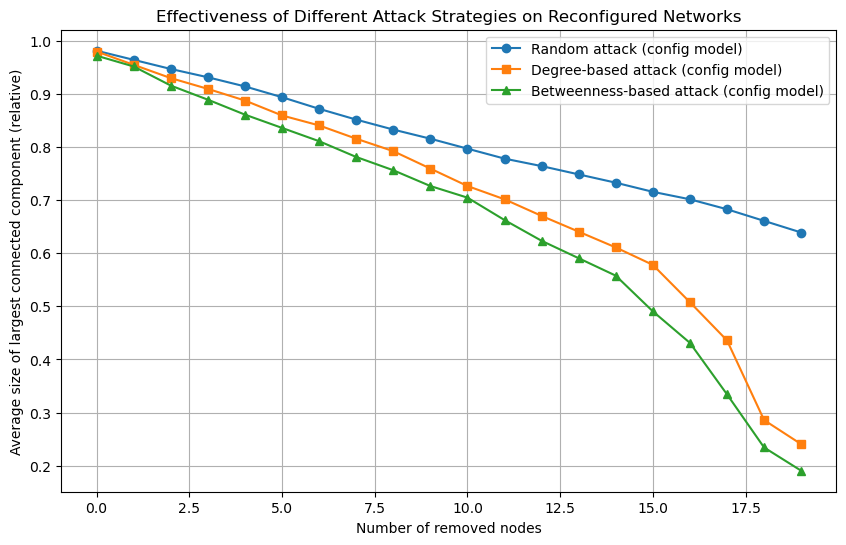

In [16]:

degree_sequence = [d for _, d in G.degree()]

results_random = []
results_degree = []
results_bc = []

for _ in range(10):
    # generate configuration model
    G_conf = nx.configuration_model(degree_sequence)
    G_conf = nx.Graph(G_conf) # removing parallel edges and self-loops
    G_conf.remove_edges_from(nx.selfloop_edges(G_conf))

    # Create copies for each attack type
    G_random = G_conf.copy()
    G_degree = G_conf.copy()
    G_bc = G_conf.copy()

    random_attack = []
    degree_attack = []
    bc_attack = []

    for _ in range(20):
        # Random attack
        G_random = attack(G_random, strategy='random')
        random_attack.append(len(max(nx.connected_components(G_random), key=len)) / len(G_conf))
        
        # Degree-based attack
        G_degree = attack(G_degree, strategy='degree')
        degree_attack.append(len(max(nx.connected_components(G_degree), key=len)) / len(G_conf))
        
        # Betweenness-based attack
        G_bc = attack(G_bc, strategy='betweenness')
        bc_attack.append(len(max(nx.connected_components(G_bc), key=len)) / len(G_conf))
    
        # Store results for averaging
        results_random.append(random_attack)
        results_degree.append(degree_attack)
        results_bc.append(bc_attack)
    
    # compute the average over the 10 trials
    avg_random = np.mean(results_random, axis=0)
    avg_degree = np.mean(results_degree, axis=0)
    avg_bc = np.mean(results_bc, axis=0)


    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(avg_random, label='Random attack (config model)', marker='o')
    plt.plot(avg_degree, label='Degree-based attack (config model)', marker='s')
    plt.plot(avg_bc, label='Betweenness-based attack (config model)', marker='^')

    plt.xlabel('Number of removed nodes')
    plt.ylabel('Average size of largest connected component (relative)')
    plt.title('Effectiveness of Different Attack Strategies on Reconfigured Networks')
    plt.legend()
    plt.grid(True)
    plt.show()

Clearly, the configuration networks are more robust to targeted attacks, whereas for random attacks the results are fairly similar.
This is because the configuration model creates a network with the same degree distribution but randomizes the connections, eliminating the scale-free structure.
In the original graph, the presence of a highly connected hub is clearly noticeable. However, the configuration model creates a more homogeneous network, removing these dominant hubs.
As a result, the configuration graphs are more robust to targeted attacks because there are no longer critical hubs whose removal would quickly fragment the network.

#### d) Attacking edges (5 pts)

Write two functions that perform an attack on an input network by deleting ``n`` edges. The first function should delete edges randomly, while the second function should perform targeted attacks, deleting the ``n`` edges with the highest/lowest value of a specified attribute. Use the function signatures in the cells below.

Make sure that your implementation does not modify the original input network and that it returns the attacked network. 

_Please note: you should not delete the edges sequentially, i.e., you should **not** recalcuate the attribute values after deleting an edge._

In [19]:
def random_edge_attack(G: nx.Graph, n: int) -> nx.Graph:
    """
    :param G: networkx graph whose edges we want to attack
    :param n: number of edges which should be attacked/deleted
    :
    :return: resulting networkx graph after deleting n edges
    """

    #This fucntion deletes edges randomly
    #First, we do a copy of the graph to avoid modifying it directly
    G = G.copy()
    #Then, we get the list of edges
    edges = list(G.edges()) 
    #And select a edge randomly
    x = random.sample(edges, n)
    G.remove_edges_from(x)
    return G
    
    

In [20]:
def target_edge_attack(G: nx.Graph, n: int, attr: str, highest: Optional[bool]=True) -> nx.Graph:
    """
    :param G: networkx graph whose edges we want to attack
    :param n: number of edges which should be attacked/deleted
    :param attr: name of the edge attribute whose values we base our attack on
    :param highest: bool indicating whether we want to delete edges with highest or lowest attribute value(s)
    :               Use highest values per default (True)
    :
    :return: resulting networkx graph after deleting n edges
    """

    #This function delete the n edges with the highest/lowest value of a specified attribute
    #First we do a copy
    G = G.copy()
    #Get edges with the specified attribute
    edges = [(u, v, data[attr]) for u, v, data in G.edges(data=True) if attr in data]  
    
    #We order the edges depending on the highest/lowest value of a specified attribute
    edges_sorted = sorted(edges, key=lambda x: x[2], reverse=highest)
    edges_to_remove = [(u, v) for u, v, _ in edges_sorted[:n]]  #Select the top n edges that meet the criteria
    
    G.remove_edges_from(edges_to_remove)
    return G

#### e) Deleting the most and least 'bridgy' edges (4 pts)

Use the neighborhood overlap function in the cell below (cf. HA 1) to compute the neighborhood overlap for each edge in the train bombing network. Create a copy of ``G`` called ``G_overlap``. Add the resulting neighborhood overlap values as edge attributes with the name ``"overlap"`` to the corresponding edges of ``G_overlap`` (do not modify ``G``). Apply each of the following three attack types on copies of ``G_overlap`` using 1d), where for each attack type you repeatedly delete 5 edges 20 times (100 edges in total):

(i) Deleting random edges,  
(ii) Deleting the edges with the highest neighborhood overlap,  
(iii) Deleting the edges with the lowest neighborhood overlap.

For each attack type start with a new (not attacked) copy of the network ``G_overlap``. Store the attacked networks in ``G_overlap_random_attack``, ``G_overlap_highest_attack`` and ``G_overlap_lowest_attack``.

Please note that you should **not** recalcuate the overlap after deleting an edge. Again, for all attack types, plot the number of removed edges against the share of the giant component in the graph. Include the curves of all three attacks in the same plot.

Which attack is the most efficient? Argue why that is the case!

In [22]:
def neighborhood_overlap(edge: Tuple[str, str], G: nx.Graph) -> float:
    """
    :param edge: pair of node IDs which indicate the edge we want to compute the node overlap on.
    :param G: networkx graph whose nodes we want to check. You may assume that it is undirected, but weighted
    :
    :return: the neighborhood overlap of the given edge as a float 
    """
    u = edge[0]
    v = edge[1]
    if G.has_edge(u, v):
        n_u = set(nx.neighbors(G, u))
        n_v = set(nx.neighbors(G, v))
        intersect = len(n_u.intersection(n_v))
        union = len(n_u.union(n_v)) - 2    
        return intersect / union
    else:
        return -1    

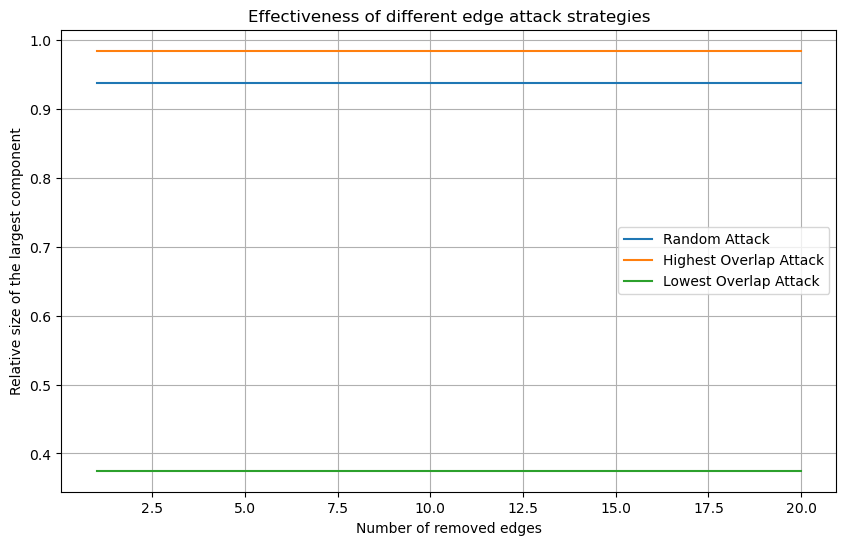

In [23]:
#First, we create the copy of G
G_overlap = G.copy()
#Then, we add the resulting neighborhood overlap values as edge attributes with the name "overlap" to the corresponding edges of G_overlap (do not modify G).
for u, v in G_overlap.edges():
    G_overlap[u][v]['overlap'] = neighborhood_overlap((u, v), G_overlap) 
    
#Now we start the different attack strategies, but first we make the copies to not modify directly
G_overlap_random_attack = G_overlap.copy()
G_overlap_highest_attack = G_overlap.copy()
G_overlap_lowest_attack = G_overlap.copy()

#So, we apply different attack strategies by iteratively removing edges
for _ in range(20):  #Perform 20 rounds of edge removal (100 edges in total)
    G_overlap_random_attack = random_edge_attack(G_overlap_random_attack, 5)  #Random attack: remove 5 edges randomly
    G_overlap_highest_attack = target_edge_attack(G_overlap_highest_attack, 5, attr='overlap', highest=True)  #Target high-overlap edges
    G_overlap_lowest_attack = target_edge_attack(G_overlap_lowest_attack, 5, attr='overlap', highest=False)  #Target low-overlap edges

#We need to create the function to track the giant component size across the attacks
def share_of_giant_component(graphs: List[nx.Graph]):
    """
    Compute the size of the largest connected component (relative to the graph size)
    after each iteration of edge removal.
    """
    sizes = []
    for G in graphs:
        G_copy = G.copy()
        size_per_step = []
        
        for _ in range(20):  #Assuming 20 iterations as before
            largest_cc = max(nx.connected_components(G_copy), key=len)
            size_per_step.append(len(largest_cc) / G_copy.number_of_nodes())
        
        sizes.append(size_per_step)

    return sizes

#Finally, we compute the results for the three attack strategies
attack_results = share_of_giant_component([
    G_overlap_random_attack, 
    G_overlap_highest_attack, 
    G_overlap_lowest_attack
])


#And the, we create a function to visualize the impact of different attack strategies
def plot_attack_results(results: List[List[float]], labels: List[str]):
    plt.figure(figsize=(10, 6))
    for size_per_step, label in zip(results, labels):
        plt.plot(range(1, 21), size_per_step, label=label)
    
    plt.xlabel("Number of removed edges")
    plt.ylabel("Relative size of the largest component")
    plt.title("Effectiveness of different edge attack strategies")
    plt.legend()
    plt.grid(True)
    plt.show()

#Call the function to visualize the effects of different attack methods
plot_attack_results(attack_results, ["Random Attack", "Highest Overlap Attack", "Lowest Overlap Attack"])


**Answer:** The most efficient attack is deleting edges with the lowest neighborhood overlap. These edges act as bridges between otherwise disconnected components. Their removal rapidly fragments the network, significantly reducing the size of the largest connected component. This observation aligns with the idea that weak ties often serve as crucial connectors in complex networks.

### Task 2: Kronecker Graphs (21 pts)

A more recently proposed graph model is built on creating huge graphs from small base graphs by utilizing the Kronecker matrix product (cf. https://en.wikipedia.org/wiki/Kronecker_product for a definition).
The main idea is to take the adjacency matrix $A$ of a small given _initiator graph_ $G$, and then define the Kronecker power graph $G^k$ as the graph whose adjacency matrix is the $k$-th power of $A$ with respect to the Kronecker product. Thus, for $G^2$, the adjacency matrix would be $ A\otimes A$, for $G^3$ the adjacency matrix would be $A\otimes A \otimes A$, and so on.

In this type of model, the entries of the adjacency matrix of the base graph can be considered as model parameters, such that (ideally) any type of large real graph can be generated by simply fitting these parameters.

#### a) Implementing the Kronecker model (4 pts)

Write a function that takes a base graph $G$ and an exponent $k$ as input, and returns the graph $G^k$, using the signature in the cell below. Make sure to also allow for directed graphs as well, i.e., $ G^k$ should be directed if and only if $G$ is directed. 

**Note:** To obtain efficient matrix representations, you may work with ```scipy.sparse```. However, the Kronecker product in ```scipy.sparse``` can introduce zeros that are explicitly represented in the sparse representation of the resulting matrix. Make sure to eliminate such zeros in time, as ```nx.from_scipy_sparse_matrix``` would create edges with weight 0 from such entries. It is also fine if you only work with ```numpy``` instead of ```scipy.sparse```. 

In [27]:
def kronecker_power_graph(G: nx.Graph, k: int) -> nx.Graph:
    """
    Computes the Kronecker power graph G^k.

    Parameters:
    G (nx.Graph): The base graph (can be directed or undirected).
    k (int): The exponent for the Kronecker power.

    Returns:
    nx.Graph: The resulting graph G^k.
    """
    # Get adjacency matrix in sparse format
    A = nx.to_scipy_sparse_array(G, dtype=int, format='csr')
    
    # Compute the Kronecker power
    Ak = A
    for _ in range(k - 1):
        Ak = sparse.kron(Ak, A, format='csr')
    
    # Remove explicit zeros
    Ak.eliminate_zeros()
    
    # Create the resulting graph, preserving directed property
    Gk = nx.from_scipy_sparse_array(Ak, create_using=nx.DiGraph if G.is_directed() else nx.Graph)
    
    return Gk

#### b) Growing two simple base graphs (6 pts)

Consider the following two base graphs specified in the cell below. For each of these two graphs, compute their Kronecker power graphs for $k\in\{2,3,4\}$, and save the resulting graphs into dictionaries `K1_graphs` and `K2_graphs`, where the keys are given by the values of $k$. Further, compute the diameters and densities of these graphs, and save them into dictionaries `K1_diameters`, `K2_diameters`, `K1_densities`, and `K2_densities`, again with using the values of $k$ as keys. 

What do you observe?

Finally, investigate the degree distributions of the Kronecker power graphs $K_1^4$ and $K_2^4$ that are created from the two base graphs and $k = 4$. 

Are the resulting degree distributions likely to occur in real-world graphs? Explain your answer!

In [29]:
K1 = nx.Graph()
K1.add_edges_from([(1,1),(2,2),(3,3),(4,4),(1,2),(2,3),(3,4)])
K2 = nx.Graph()
K2.add_edges_from([(1,1),(2,2),(3,3),(4,4),(1,2),(2,3),(3,4),(2,4)])

In [30]:
# Compute Kronecker graphs, diameters, and densities
K1_graphs, K2_graphs = {}, {}
K1_diameters, K2_diameters = {}, {}
K1_densities, K2_densities = {}, {}

for k in [2, 3, 4]:
    K1_graphs[k] = kronecker_power_graph(K1, k)
    K2_graphs[k] = kronecker_power_graph(K2, k)
    
    K1_diameters[k] = nx.diameter(K1_graphs[k]) if nx.is_connected(K1_graphs[k]) else float('inf')
    K2_diameters[k] = nx.diameter(K2_graphs[k]) if nx.is_connected(K2_graphs[k]) else float('inf')
    
    K1_densities[k] = nx.density(K1_graphs[k])
    K2_densities[k] = nx.density(K2_graphs[k])

# Degree distributions for K1^4 and K2^4
K1_degree_dist = [d for _, d in K1_graphs[4].degree()]
K2_degree_dist = [d for _, d in K2_graphs[4].degree()]

# Observations
observations = {
    "K1_diameters": K1_diameters,
    "K2_diameters": K2_diameters,
    "K1_densities": K1_densities,
    "K2_densities": K2_densities,
    "K1_degree_distribution": K1_degree_dist,
    "K2_degree_distribution": K2_degree_dist,
}

observations


{'K1_diameters': {2: 3, 3: 3, 4: 3},
 'K2_diameters': {2: 2, 3: 2, 4: 2},
 'K1_densities': {2: 0.48333333333333334,
  3: 0.2638888888888889,
  4: 0.1571078431372549},
 'K2_densities': {2: 0.6666666666666666,
  3: 0.4444444444444444,
  4: 0.3215686274509804},
 'K1_degree_distribution': [17,
  25,
  25,
  17,
  25,
  37,
  37,
  25,
  25,
  37,
  37,
  25,
  17,
  25,
  25,
  17,
  25,
  37,
  37,
  25,
  37,
  55,
  55,
  37,
  37,
  55,
  55,
  37,
  25,
  37,
  37,
  25,
  25,
  37,
  37,
  25,
  37,
  55,
  55,
  37,
  37,
  55,
  55,
  37,
  25,
  37,
  37,
  25,
  17,
  25,
  25,
  17,
  25,
  37,
  37,
  25,
  25,
  37,
  37,
  25,
  17,
  25,
  25,
  17,
  25,
  37,
  37,
  25,
  37,
  55,
  55,
  37,
  37,
  55,
  55,
  37,
  25,
  37,
  37,
  25,
  37,
  55,
  55,
  37,
  55,
  82,
  82,
  55,
  55,
  82,
  82,
  55,
  37,
  55,
  55,
  37,
  37,
  55,
  55,
  37,
  55,
  82,
  82,
  55,
  55,
  82,
  82,
  55,
  37,
  55,
  55,
  37,
  25,
  37,
  37,
  25,
  37,
  55,
  55,
 

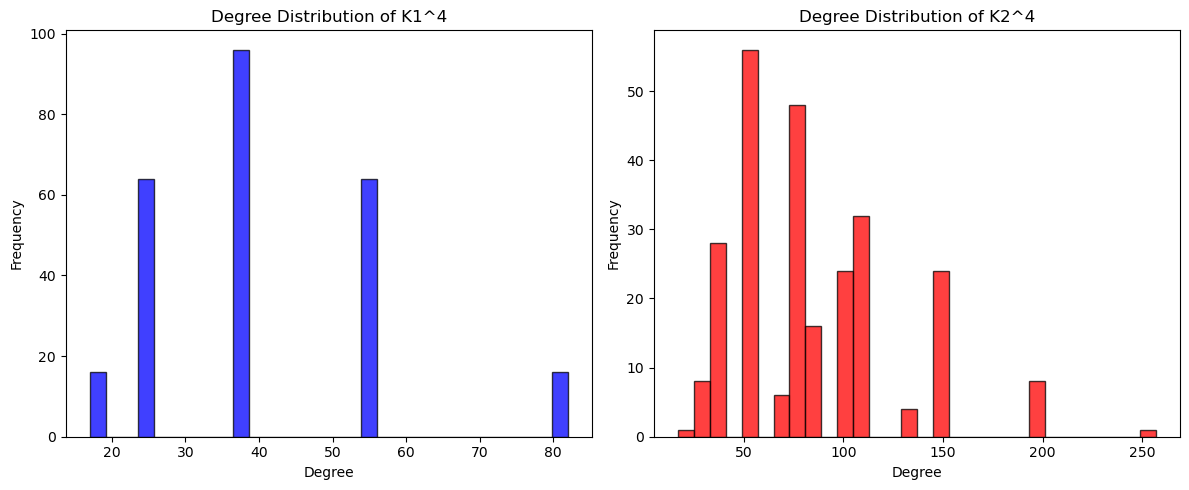

In [31]:
# Plot degree distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(K1_degree_dist, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of K1^4")

plt.subplot(1, 2, 2)
plt.hist(K2_degree_dist, bins=30, alpha=0.75, color='red', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of K2^4")

plt.tight_layout()
plt.show()

**Answer:** 

### Observations:

1. **Diameter Trends**:
   - The diameters of \( K_1^k \) are constant at 3 for \( k=2,3,4 \).
   - The diameters of \( K_2^k \) are constant at 2 for \( k=2,3,4 \).
   - This suggests that adding Kronecker powers increases the graph size but does not significantly increase the longest shortest path between nodes.

2. **Density Trends**:
   - The density of both graphs decreases as \( k \) increases.
   - \( K_1 \) starts with a lower density compared to \( K_2 \), and this trend persists as \( k \) grows.
   - This indicates that the graphs become sparser with increasing \( k \), which aligns with real-world networks that exhibit scale-free properties.

3. **Degree Distributions**:
   - The degree distributions for \( K_1^4 \) and \( K_2^4 \) show a variety of degree values, but they do not appear to follow a power-law distribution.
   - In real-world networks, such as social or biological networks, we often observe a small number of highly connected nodes (hubs) and many nodes with fewer connections.
   - The Kronecker model does not inherently enforce such power-law properties, leading to distributions that may not align with real-world graphs.

### Conclusion:
The Kronecker graphs exhibit some properties of real-world networks, such as increasing sparsity, but they do not naturally generate the heavy-tailed degree distributions typically found in social and technological networks. This suggests that while the Kronecker model can be useful for synthetic graph generation, additional tuning may be necessary to better match real-world graph structures.

#### c) Stochastic Kronecker graphs (4 pts)

As the expressive power of Kronecker graphs is somewhat limited, in a sense that many real-world degree distributions cannot be modeled, there is also a stochastic variant of the Kronecker model.
In this variant, the input to the model is a matrix $P$, in which the entries are not binary anymore (like in an adjacency matrix), but instead can take any value in the interval $[0,1]$. Thus, each entry $P_{ij}$ encodes the probability that an edge is formed between nodes $i$ and $j$.
For a small input matrix $P$, we again grow a bigger matrix by taking its Kronecker powers, and for the final $P^k$ we then randomly add edges according to the probabilities in the entries $P^k_{ij}$.

Implement this probabilistic variant of the Kronecker model, using the signature in the cell below. Note that this time you cannot use sparse matrices anymore. Further, for this model we exclusively consider directed networks!

In [34]:
def probabilistic_kronecker(P: np.ndarray, k: int) -> nx.DiGraph:
    """
    :param P: 2D numpy array of edge probabilities to compute the graph from
    :param k: Kronecker power to compute
    :
    :return: resulting Kronecker power graph as a DIRECTED networkx graph
    """
    P_k = P
    for _ in range(k - 1):
        P_k = np.kron(P_k, P)
    
    n = P_k.shape[0]
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    
    for i in range(n):
        for j in range(n):
            if np.random.rand() < P_k[i, j]:
                G.add_edge(i, j)
    
    return G


#### d) Fitting Kronecker graphs (7 pts)

Apply your implementation from __c)__ to create a graph with $n=1024$ nodes with a desired degree distribution from a $2\times 2$ base matrix $P$.
Determine  
(i) a base matrix $P_1$ such that the resulting graph has a Poisson degree distribution (or similar).  
(ii) a base matrix $P_2$ such that the resulting graph has a power law degree distribution (or similar).

Save the corresponding matrices as numpy arrays into variables ```P1``` and ```P2```, and plot the degree distributions (you may use in-degree, out-degree, or their sum) of the resulting Konecker graphs for verification. Make sure to use expressive plots for that purpose.

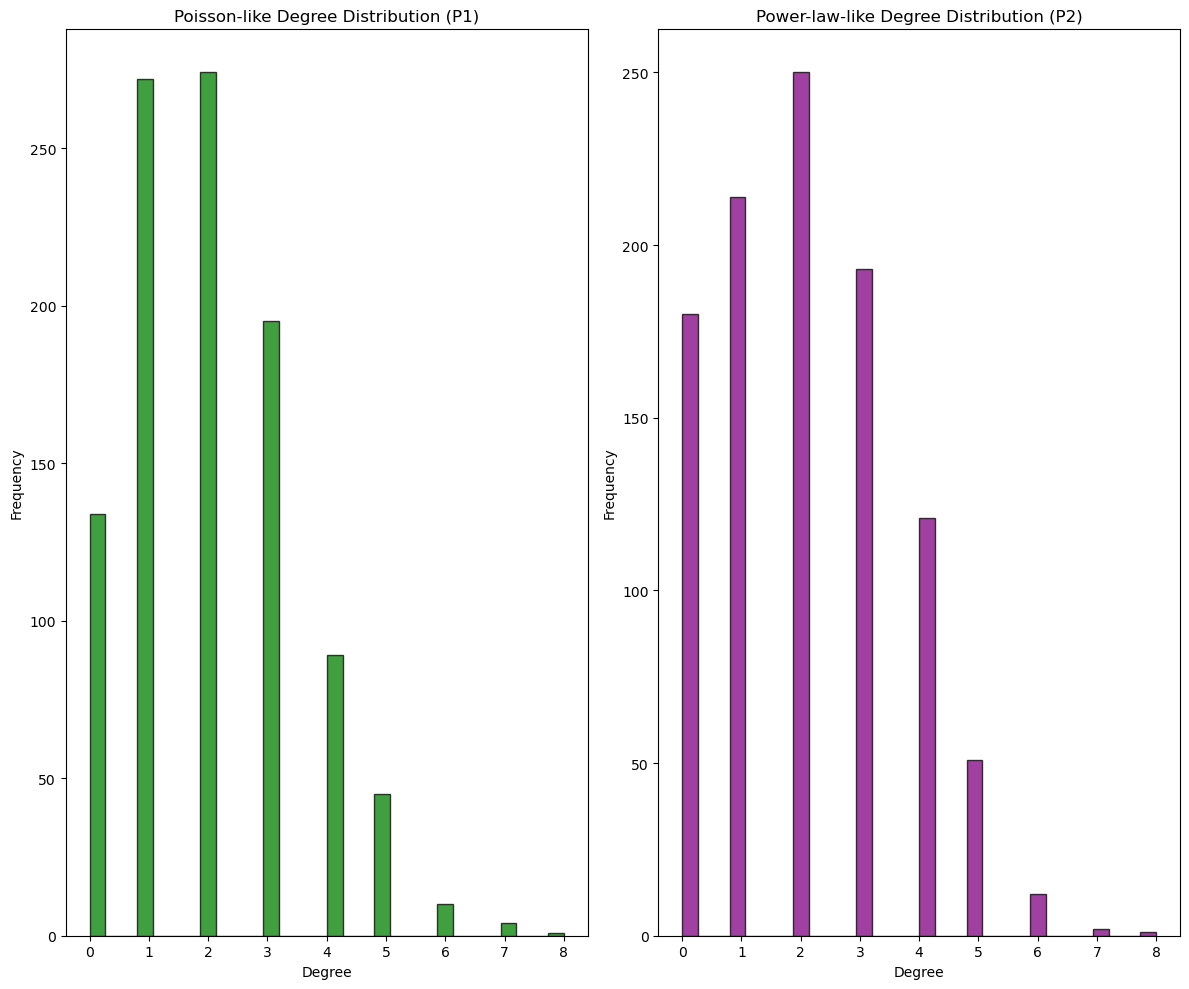

In [36]:
# Define base matrices for Poisson and Power-law distributions
P1 = np.array([[0.5, 0.5], [0.5, 0.5]])  # Poisson-like distribution
P2 = np.array([[0.9, 0.1], [0.1, 0.9]])  # Power-law-like distribution

# Generate stochastic Kronecker graphs
G_P1 = probabilistic_kronecker(P1, 10) #2**10 = 1024
G_P2 = probabilistic_kronecker(P2, 10)


# Degree distributions for stochastic graphs
P1_in_degree_dist = [d for _, d in G_P1.in_degree()]
P1_out_degree_dist = [d for _, d in G_P1.out_degree()]
P1_total_degree_dist = [in_d + out_d for in_d, out_d in zip(P1_in_degree_dist, P1_out_degree_dist)]

P2_in_degree_dist = [d for _, d in G_P2.in_degree()]
P2_out_degree_dist = [d for _, d in G_P2.out_degree()]
P2_total_degree_dist = [in_d + out_d for in_d, out_d in zip(P2_in_degree_dist, P2_out_degree_dist)]


plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.hist(P1_total_degree_dist, bins=30, alpha=0.75, color='green', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Poisson-like Degree Distribution (P1)")

plt.subplot(1, 2, 2)
plt.hist(P2_total_degree_dist, bins=30, alpha=0.75, color='purple', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Power-law-like Degree Distribution (P2)")

plt.tight_layout()
plt.show()
